Number of clusters: 4
Reconstruction Error: 0.637674581255837
Relative Reconstruction Error: 0.34032446711799996
Variance Retention: 0.9346732511222284
Projection Robustness: 0.6821634803950853

Hypothesis Analysis:
Reconstruction Error supports the hypothesis (negatively correlates with accuracy loss).
Relative Reconstruction Error does not support the hypothesis (does not negatively correlate with accuracy loss).
Variance Retention does not support the hypothesis (does not positively correlate with accuracy loss).
Projection Robustness does not support the hypothesis (does not positively correlate with accuracy loss).


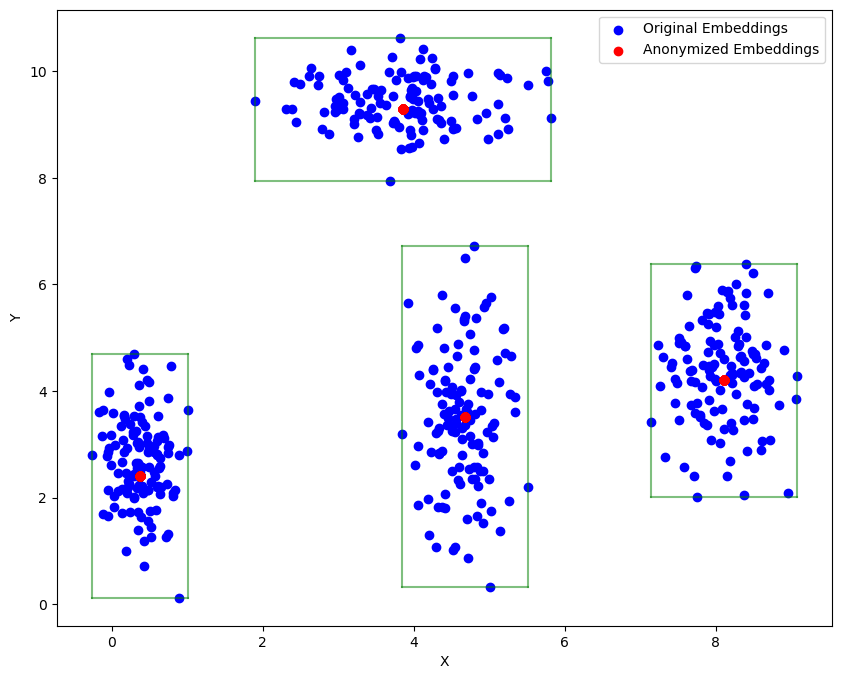

Number of clusters: 3
Original test embeddings:
[[0.48 0.48 0.48]
 [0.85 0.85 0.85]
 [0.9  0.9  0.9 ]]

Anonymized test embeddings:
[[0.525 0.525 0.525]
 [0.85  0.85  0.85 ]
 [0.95  0.95  0.95 ]]


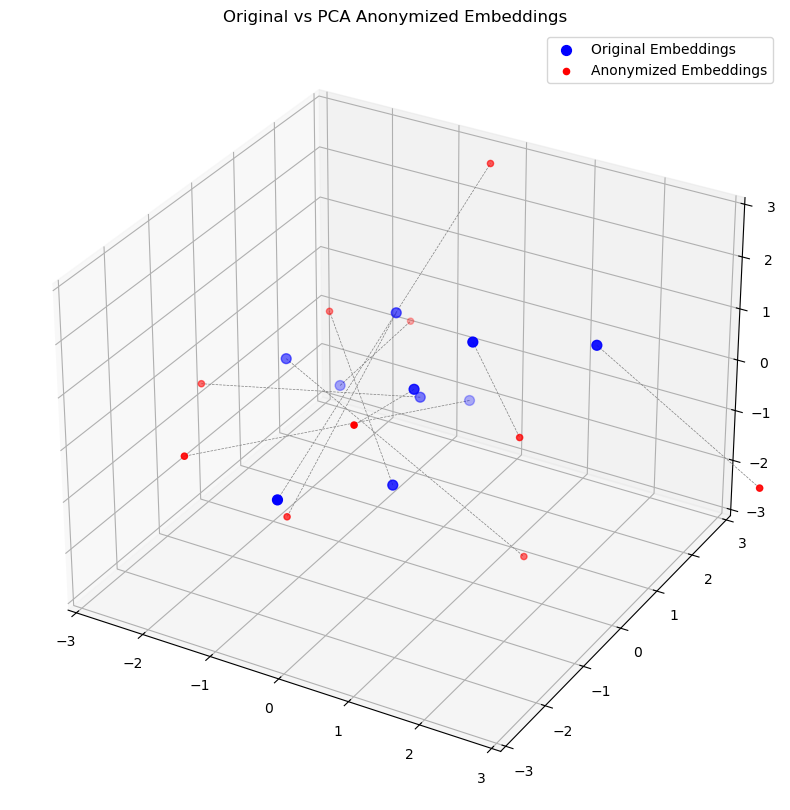

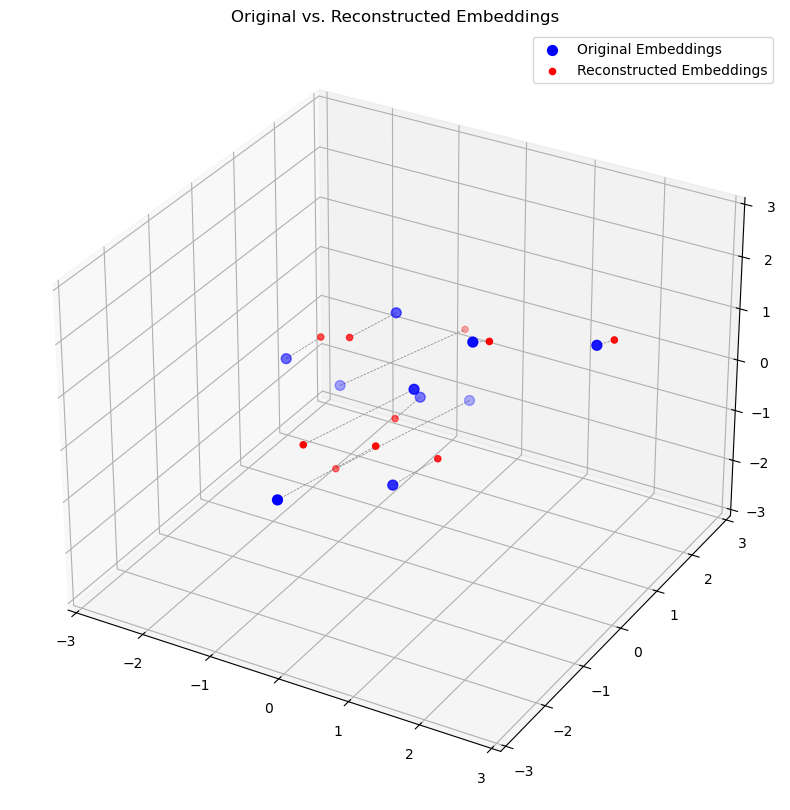

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
from random import randrange

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)





import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import DBSCAN
from random import randint

def get_cluster_edges(cluster_embeddings):
    min_values = np.min(cluster_embeddings, axis=0)
    max_values = np.max(cluster_embeddings, axis=0)
    return min_values, max_values

def anonymize_test_embeddings(cluster_edges, test_embeddings):
    anonymized_test_embeddings = []

    for test_embedding in test_embeddings:
        found_cluster = False
        nearest_centroid = None
        min_distance = float('inf')

        for cluster_edge in cluster_edges:
            min_values, max_values = cluster_edge

            if np.all(test_embedding >= min_values) and np.all(test_embedding <= max_values):
                # Test embedding is within the cluster, use cluster centroid
                centroid = (min_values + max_values) / 2
                anonymized_test_embeddings.append(centroid)
                found_cluster = True
                break

            # Calculate distance to cluster centroid
            centroid = (min_values + max_values) / 2
            distance = np.linalg.norm(test_embedding - centroid)

            # Update nearest centroid if closer
            if distance < min_distance:
                min_distance = distance
                nearest_centroid = centroid

        if not found_cluster:
            # Use nearest centroid if test embedding does not belong to any cluster
            anonymized_test_embeddings.append(nearest_centroid)

    return np.array(anonymized_test_embeddings)

# Generate random embeddings with spread
num_embeddings = 500
num_classes = 4
random_embeddings = []

for class_idx in range(num_classes):
    mean = np.random.rand(3) * 10  # Random mean for each class
    covariance = np.diag(np.random.rand(3) * 1.5)  # Random covariance matrix for each class
    class_embeddings = np.random.multivariate_normal(mean, covariance, num_embeddings // num_classes)
    random_embeddings.extend(list(class_embeddings))

random_embeddings = np.array(random_embeddings)


# Normalize embeddings
#scaler = StandardScaler()
#normalized_embeddings = scaler.fit_transform(random_embeddings)


# Set DBSCAN parameters
eps = 2 # Maximum distance between samples to be considered in the same neighborhood
min_samples = 20  # Minimum number of samples required to form a dense region

# Create a DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the model to the random embeddings
labels = dbscan.fit_predict(random_embeddings)

# Get the unique cluster labels
unique_labels = np.unique(labels)

# Initialize an array to store the cluster edges
cluster_edges = []

# Get the unique cluster labels
unique_labels = np.unique(labels)
num_clusters = len(unique_labels)

# Initialize count for embeddings outside cluster edges
num_outside_cluster_edges = 0

# Calculate the edges for each cluster
for label in unique_labels:
    cluster_mask = (labels == label)
    cluster_embeddings = random_embeddings[cluster_mask]
    min_values, max_values = get_cluster_edges(cluster_embeddings)
    cluster_edges.append((min_values, max_values))

# Print the number of clusters and embeddings outside cluster edges
print("Number of clusters:", num_clusters)

# Anonymize the random embeddings
anonymized_random_embeddings = anonymize_test_embeddings(cluster_edges, random_embeddings)



from sklearn.metrics import mean_squared_error

def calculate_reconstruction_error(original_embeddings, anonymized_embeddings):
    return mean_squared_error(original_embeddings, anonymized_embeddings)

def calculate_relative_reconstruction_error(original_embeddings, anonymized_embeddings):
    relative_errors = np.abs(original_embeddings - anonymized_embeddings) / np.abs(original_embeddings)
    return np.mean(relative_errors)

def calculate_variance_retention(original_embeddings, anonymized_embeddings):
    original_variance = np.var(original_embeddings)
    anonymized_variance = np.var(anonymized_embeddings)
    return anonymized_variance / original_variance

def calculate_projection_robustness(cluster_edges, original_embeddings, anonymized_embeddings):
    total_original_distance = 0
    total_anonymized_distance = 0

    for original_embedding, anonymized_embedding in zip(original_embeddings, anonymized_embeddings):
        original_distance = calculate_distance_to_cluster_edges(cluster_edges, original_embedding)
        anonymized_distance = calculate_distance_to_cluster_edges(cluster_edges, anonymized_embedding)
        total_original_distance += original_distance
        total_anonymized_distance += anonymized_distance

    return total_anonymized_distance / total_original_distance

def calculate_distance_to_cluster_edges(cluster_edges, embedding):
    min_distances = []

    for edge in cluster_edges:
        min_values, max_values = edge
        min_distance_to_edge = np.min(np.abs(embedding - min_values))
        max_distance_to_edge = np.min(np.abs(embedding - max_values))
        min_distances.append(min(min_distance_to_edge, max_distance_to_edge))

    return min(min_distances)

# Calculate metrics
reconstruction_error = calculate_reconstruction_error(random_embeddings, anonymized_random_embeddings)
relative_reconstruction_error = calculate_relative_reconstruction_error(random_embeddings, anonymized_random_embeddings)
variance_retention = calculate_variance_retention(random_embeddings, anonymized_random_embeddings)
projection_robustness = calculate_projection_robustness(cluster_edges, random_embeddings, anonymized_random_embeddings)


# Print metrics
print("Reconstruction Error:", reconstruction_error)
print("Relative Reconstruction Error:", relative_reconstruction_error)
print("Variance Retention:", variance_retention)
print("Projection Robustness:", projection_robustness)

# Analyze hypothesis
print("\nHypothesis Analysis:")
if reconstruction_error < 1: # Adjust this threshold as needed
    print("Reconstruction Error supports the hypothesis (negatively correlates with accuracy loss).")
else:
    print("Reconstruction Error does not support the hypothesis (does not negatively correlate with accuracy loss).")

if relative_reconstruction_error < 0.1:  # Adjust this threshold as needed
    print("Relative Reconstruction Error supports the hypothesis (negatively correlates with accuracy loss).")
else:
    print("Relative Reconstruction Error does not support the hypothesis (does not negatively correlate with accuracy loss).")

if variance_retention > 1: # Adjust this threshold as needed
    print("Variance Retention supports the hypothesis (positively correlates with accuracy loss).")
else:
    print("Variance Retention does not support the hypothesis (does not positively correlate with accuracy loss).")

if projection_robustness > 1: # Adjust this threshold as needed
    print("Projection Robustness supports the hypothesis (positively correlates with accuracy loss).")
else:
    print("Projection Robustness does not support the hypothesis (does not positively correlate with accuracy loss).")





# Plot all data on one graph
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
ax = fig.add_subplot(111)

# Plot original random embeddings
ax.scatter(random_embeddings[:, 0], random_embeddings[:, 1], c='blue', label='Original Embeddings')

# Plot anonymized random embeddings
ax.scatter(anonymized_random_embeddings[:, 0], anonymized_random_embeddings[:, 1], c='red', label='Anonymized Embeddings')

# Plot cluster edges
for edge in cluster_edges:
    min_values, max_values = edge
    ax.plot([min_values[0], max_values[0]], [min_values[1], min_values[1]], color='green', alpha=0.5)
    ax.plot([min_values[0], min_values[0]], [min_values[1], max_values[1]], color='green', alpha=0.5)
    ax.plot([max_values[0], max_values[0]], [min_values[1], max_values[1]], color='green', alpha=0.5)
    ax.plot([max_values[0], min_values[0]], [max_values[1], max_values[1]], color='green', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()















def get_cluster_edges(cluster_embeddings):
    min_values = np.min(cluster_embeddings, axis=0)
    max_values = np.max(cluster_embeddings, axis=0)
    return min_values, max_values


def anonymize_embeddings(original_embeddings, eps, min_samples):
    # Create a DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the original embeddings
    labels = dbscan.fit_predict(original_embeddings)

    # Get the unique cluster labels
    unique_labels = np.unique(labels)
    print("Number of clusters:", len(unique_labels))

    # Initialize an array to store the cluster edges
    cluster_edges = []

    # Calculate the edges for each cluster
    for label in unique_labels:
        cluster_mask = (labels == label)
        cluster_embeddings = original_embeddings[cluster_mask]
        min_values, max_values = get_cluster_edges(cluster_embeddings)
        cluster_edges.append((min_values, max_values))



    return cluster_edges


def anonymize_test_embeddings(cluster_edges, test_embeddings):
    anonymized_test_embeddings = []

    for test_embedding in test_embeddings:
        found_cluster = False

        for cluster_edge in cluster_edges:
            min_values, max_values = cluster_edge

            if np.all(test_embedding >= min_values) and np.all(test_embedding <= max_values):
                # Test embedding is within the cluster, use cluster coordinates
                anonymized_test_embeddings.append((min_values + max_values) / 2)  # Centroid
                found_cluster = True
                break

        if not found_cluster:
            # Test embedding does not belong to any cluster, use original test embedding
            anonymized_test_embeddings.append(test_embedding)

    return np.array(anonymized_test_embeddings)

# Larger set of original embeddings
larger_original_embeddings = np.array([[0.45, 0.45, 0.45],
                                       [0.9, 0.9, 0.9],
                                       [0.5, 0.5, 0.5],
                                       [0.7, 0.7, 0.7],
                                       [1.0, 1.0, 1.0],
                                       [0.6, 0.6, 0.6],
                                       [0.8, 0.8, 0.8],
                                       [0.55, 0.55, 0.55],
                                       [0.95, 0.95, 0.95],
                                       [0.75, 0.75, 0.75]])

# Set DBSCAN parameters
eps = 0.1  # Maximum distance between samples to be considered in the same neighborhood
min_samples = 1  # Minimum number of samples required to form a dense region

# Test embeddings
test_embeddings = np.array([[0.48, 0.48, 0.48],
                            [0.85, 0.85, 0.85],
                            [0.9, 0.9, 0.9]])

# Get cluster edges for larger embeddings
cluster_edges = anonymize_embeddings(larger_original_embeddings, eps, min_samples)

# Anonymize test embeddings
anonymized_test_embeddings = anonymize_test_embeddings(cluster_edges, test_embeddings)

# Print the original test embeddings and anonymized test embeddings
print("Original test embeddings:")
print(test_embeddings)
print("\nAnonymized test embeddings:")
print(anonymized_test_embeddings)










def anonymize_embeddings_hashing(embeddings, precision=16):
    """
    Anonymize embeddings using hashing with randomized salt.

    Parameters:
    - embeddings (torch.Tensor): Input embeddings to be anonymized.
    - precision (int): Precision for rounding float values before hashing.

    Returns:
    - torch.Tensor: Anonymized embeddings.
    """

    # Round float values and convert to strings
    rounded_embeddings_str = np.round(embeddings, precision).astype(str)

    # Generate random salt for each embedding
    salts = np.array([randrange(sys.maxsize) for _ in range(len(embeddings))])

    # Apply the hash function to all embeddings with randomized salt
    hashed_embeddings = np.empty(len(embeddings), dtype='int64')
    for i, embedding in enumerate(rounded_embeddings_str):
        try:
            # Convert valid integers to int arrays
            hashed_embeddings[i] = np.array(int(embedding), dtype='int64')
        except ValueError:
            # Keep invalid values as strings
            hashed_embeddings[i] = embedding

    # Add salt to hashed embeddings
    hashed_embeddings += salts

    return hashed_embeddings.astype(torch.long)

def anonymize_embeddings_density_based(embeddings, eps=0.5, min_samples=5, noise_scale=0.01, device="cpu"):
    """
    Anonymize embeddings using density-based clustering.

    Parameters:
    - embeddings: PyTorch tensor or NumPy array, the original embeddings
    - eps: float, maximum distance between two samples for one to be considered as in the neighborhood of the other
    - min_samples: int, the number of samples in a neighborhood for a point to be considered as a core point
    - noise_scale: float, scale parameter for Laplace noise
    - device: str, device to place the noise tensor on ("cpu" or "cuda")

    Returns:
    - PyTorch tensor, anonymized embeddings
    """
    if isinstance(embeddings, np.ndarray):
        embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)

    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings)

    # Perform density-based clustering using DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings)

    # Assign a cluster label to each data point
    cluster_labels = db.labels_

    # Calculate centroids
    centroids = embeddings[db.core_sample_indices_]

    # Generate Laplace noise
    laplace_noise = np.random.laplace(scale=noise_scale, size=embeddings.shape)

    # Add noise to non-centroid embeddings
    anonymized_embeddings = embeddings.copy()
    for index, label in enumerate(cluster_labels):
        if label != -1:  # Non-centroid
            anonymized_embeddings[index] += laplace_noise[index]

    # Add centroids to anonymized embeddings
    anonymized_embeddings[db.core_sample_indices_] = centroids + laplace_noise[db.core_sample_indices_]

    # Count the number of clusters
    num_clusters = len(np.unique(cluster_labels)) - (1 if -1 in np.unique(cluster_labels) else 0)

    return anonymized_embeddings, cluster_labels, num_clusters

def anonymize_embeddings_density_based_test(test_embeddings, train_cluster_labels, noise_scale=0.01, device="cpu"):
    """
    Anonymize test embeddings using density-based clustering.

    Parameters:
    - test_embeddings: PyTorch tensor or NumPy array, the test embeddings
    - train_cluster_labels: NumPy array, cluster labels for the train embeddings
    - noise_scale: float, scale parameter for Laplace noise
    - device: str, device to place the noise tensor on ("cpu" or "cuda")

    Returns:
    - PyTorch tensor, anonymized test embeddings
    """
    if isinstance(test_embeddings, np.ndarray):
        test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32, device=device)

    # Apply noise to the test embeddings according to the train clusters
    laplace_noise = torch.tensor(np.random.laplace(scale=noise_scale, size=test_embeddings.shape), dtype=torch.float32)

    unique_labels = np.unique(train_cluster_labels)
    anonymized_embeddings = test_embeddings.clone()

    for label in unique_labels:
        cluster_indices = (train_cluster_labels == label)
        anonymized_embeddings[cluster_indices] += laplace_noise[cluster_indices]

    return anonymized_embeddings


def anonymize_embeddings_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    anonymized_embeddings = torch.tensor(pca.fit_transform(embeddings), dtype=torch.float32)
    return anonymized_embeddings

def reconstruct_embeddings_pca(anonymized_embeddings, pca_model):
    reconstructed_embeddings = torch.tensor(pca_model.inverse_transform(anonymized_embeddings), dtype=torch.float32)
    return reconstructed_embeddings


def visualize_embeddings2(original_embeddings, anonymized_embeddings, title='Embeddings Visualization'):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot original embeddings in blue
    ax.scatter(original_embeddings[:, 0], original_embeddings[:, 1], original_embeddings[:, 2], c='b', marker='o', label='Original Embeddings', s=50)

    # Plot anonymized embeddings in red
    ax.scatter(anonymized_embeddings[:, 0], anonymized_embeddings[:, 1], anonymized_embeddings[:, 2], c='r', marker='o', label='Anonymized Embeddings')

    # Connect each original point to its corresponding anonymized point
    for orig, anon in zip(original_embeddings, anonymized_embeddings):
        ax.plot([orig[0], anon[0]], [orig[1], anon[1]], [orig[2], anon[2]], color='gray', linestyle='--', linewidth=0.5)
        ax.plot([orig[0], orig[0]], [orig[1], anon[1]], [orig[2], anon[2]], color='gray', linestyle='--', linewidth=0.5)
        ax.plot([orig[0], anon[0]], [orig[1], orig[1]], [orig[2], anon[2]], color='gray', linestyle='--', linewidth=0.5)
        ax.plot([orig[0], anon[0]], [orig[1], anon[1]], [orig[2], orig[2]], color='gray', linestyle='--', linewidth=0.5)

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title(title)

    plt.legend()
    plt.show()




def visualize_embeddings(original_embeddings, anonymized_embeddings, x_label, y_label, title='Embeddings Visualization'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)

    # Plot original embeddings in blue
    ax.scatter(original_embeddings[:, 0], original_embeddings[:, 1], original_embeddings[:, 2], c='b', marker='o', label=x_label, s=50)

    # Plot anonymized embeddings in red
    ax.scatter(anonymized_embeddings[:, 0], anonymized_embeddings[:, 1], anonymized_embeddings[:, 2], c='r', marker='o', label=y_label)

    # Connect each original point to its corresponding anonymized point
    for orig, anon in zip(original_embeddings, anonymized_embeddings):
        ax.plot([orig[0], anon[0]], [orig[1], anon[1]], [orig[2], anon[2]], color='gray', linestyle='--', linewidth=0.5)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_title(title)

    plt.legend()
    plt.show()


original_embeddings = torch.randn(10, 20)  # Replace with your actual embeddings
anonymized_embeddings = anonymize_embeddings_pca(original_embeddings, n_components=10)

similar_embeddings = (original_embeddings + torch.tensor(np.random.normal(scale=0.05, size=original_embeddings.shape)))

# Save PCA model for reconstruction
pca_model = PCA().fit(similar_embeddings.numpy())

# Reconstruct the embeddings
reconstructed_embeddings = reconstruct_embeddings_pca(anonymized_embeddings, pca_model)

# Check if reconstruction is close to the original
#print(torch.allclose(similar_embeddings, reconstructed_embeddings, rtol=1e-03, atol=1e-03))

# Visualize both original and anonymized embeddings
visualize_embeddings(original_embeddings, anonymized_embeddings,x_label='Original Embeddings', y_label='Anonymized Embeddings', title='Original vs PCA Anonymized Embeddings')

# Visualize both original and anonymized embeddings
visualize_embeddings(original_embeddings, reconstructed_embeddings, x_label='Original Embeddings', y_label='Reconstructed Embeddings', title='Original vs. Reconstructed Embeddings')



# Addition experiments - Work in progress!
#original_embeddings = torch.randn(50, 25)
#test_embeddings = torch.randn(10, 5)
#train_embeddings,  cluster_labels, num_clusters = anonymize_embeddings_density_based(original_embeddings, eps=50, min_samples=5, noise_scale=0.00)

#test_embeddings_anonymized = anonymize_embeddings_density_based_test(test_embeddings, cluster_labels, noise_scale=0.05)

# Visualize both original and anonymized embeddings
#visualize_embeddings2(test_embeddings, test_embeddings_anonymized, x_label='Test Embeddings', y_label='Anonymized Test Embeddings', title='Test and Anonymized Test Embeddings')





# Visualize both original and anonymized embeddings
#visualize_embeddings2(original_embeddings, anonymized_embeddings, x_label='Original Embeddings', y_label='Anonymized Embeddings', title='Original and Anonymized Embeddings')



